In [2]:
from __future__ import division
import torch
import numpy as np
import math
from PIL import Image
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


The next few cells contains code for the generative process for observations:

In [3]:
def dirichletDistSample(alphas):
    x = np.zeros([len(alphas),1])
    i = 0
    for a in alphas:
        x[i] = np.random.gamma(a,1)
        i+=1
    sum = np.sum(x)
    return np.divide(x,sum)

In [4]:
def gamma(val):
    return math.factorial(val-1)
    

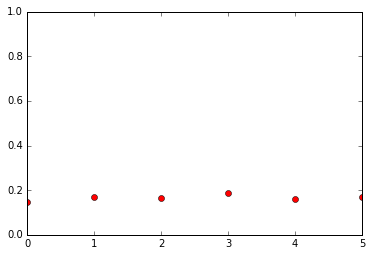

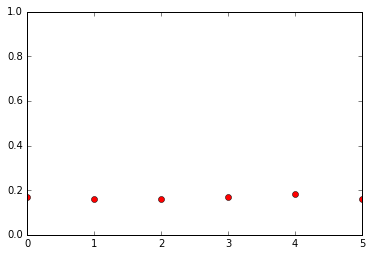

In [44]:
for i in range(2):
    x = [100] *6
    plt.plot(dirichletDistSample(x),'ro')
    plt.axis([0,5,0,1])
    plt.show()

In [ ]:
print(np.random.randint(1,16,1))
n_alp = 16
alphas = [.01] * n_alp
sss = np.random.dirichlet(alphas,1)
print(np.asarray(sss))
print(sss.shape)
print(np.random.choice(a = np.arange(0,16), p = np.squeeze(sss)))

In [5]:
#alphas and betas are lists containing the parameter values
n_alp = 16
alphas = [.01] * n_alp
n_bet = 10
betas = [.01] * n_bet

def initializeCanvas( alphas ):
    
    canvas = np.zeros([100,100])
    no_of_topics = len(alphas)
    for r in range(100):
        for c in range(100):
            
            canvas[r,c] = np.random.randint(1,16,1) *16
    
    img = Image.fromarray(canvas)
    img.show()
    
    return canvas
initializeCanvas(alphas)

array([[160., 112., 208., ...,  48.,  80., 176.],
       [176., 176.,  16., ..., 128., 128., 192.],
       [144., 144., 160., ...,  80.,  80.,  16.],
       ...,
       [ 80.,  16., 224., ..., 128., 112., 224.],
       [160., 144., 128., ..., 224., 128.,  96.],
       [ 48., 160., 192., ..., 176., 128.,  32.]])

In [6]:
def noOfTopicsInNeighbourhood(r,c,canvas , window):
    
    counter = np.zeros(16)
    val = canvas[r,c]
    #counter = -1
    for i in range(max(0,r-window),min(canvas.shape[0],r+window)):
        for j in range(max(0,c-window),min(canvas.shape[1],c+window)):
            counter[int(canvas[i,j]/16)-1]=counter[int(canvas[i,j]/16)-1]+1
    #print(counter)
    return counter

In [7]:
def generativeDirichlet(alphas,window):
    #window = 1
    init_canvas = initializeCanvas(alphas)
    for n in range(100):
        
        for r in range(100):
            
            for c in range(100):
                
                n_k = noOfTopicsInNeighbourhood(r,c, init_canvas , window)
                update_arr = np.zeros(len(alphas))
                #print(n)
                #update_arr[int(init_canvas[r,c]/16)-1] = n_k
                update_arr = n_k
                cur_alpha = np.squeeze(np.asarray(alphas))+update_arr
                #cur_alpha = np.divide(cur_alpha,sum(cur_alpha))
                #print(cur_alpha)
                dist = np.random.dirichlet(cur_alpha,1)
                init_canvas[r,c] = np.random.choice(a = np.arange(1,17), p = np.squeeze(dist))*16
        #print(n)
    img = Image.fromarray(init_canvas)
    img.show()
    return init_canvas

In [30]:
n_alp = 16
alphas = [.01] * n_alp
cc = generativeDirichlet(alphas,2)

Performing Topic modelling on images (ROST) :

In [8]:
#given a blank dictionary, the number of topics and the vocab, this fuction creates a blank slate to write the topics
#in the randomTopicInit() method
def createTopicDicts(dict_topics , no_of_topics , vocab):
    
    tstr = "topic"
    for i in range(1,no_of_topics+1):
        dict_topics[tstr+str(i)] = {}
        for word in vocab:
            dict_topics[tstr+str(i)][str(word)] = 0
        dict_topics[tstr+str(i)]["total_words"] = 0
    print("created_topic_dict", dict_topics )
    return dict_topics

createDocDicts() : given an empty dictionary creates a dictionay where the keys are the number of documents present in the corpus. This is equivalent to the number of cells in which a single image frame is broken into.

In [9]:

def createDocDicts(dict_docs,doc_counter,no_of_topics):
    dict_docs[str("doc"+str(doc_counter))] = {}
    dict_docs[str("doc"+str(doc_counter))]["total_topics"] = 0
    for i in range(1,no_of_topics+1):
        dict_docs[str("doc"+str(doc_counter))]["topic"+str(i)] = 0
    return dict_docs

createDocDictsROST(): similar to the previous function, but generates a 2d document structure instead of 1D. useful for neighbourhood calculation.

In [10]:
def createDocDictsROST(dict_docs , row , col , no_of_topics):
    dict_docs["doc_{0}_{1}".format(row,col)] = {}
    dict_docs["doc_{0}_{1}".format(row,col)]["total_topics"] = 0
    for i in range(1,no_of_topics+1):
        dict_docs["doc_{0}_{1}".format(row,col)]["topic"+str(i)] = 0
    return dict_docs

randomTopicInit(): given a corpus and number of topics and the vocab, this functions assigns a topic to each of the word at random. This returns a word distribution for each topic (dict_topics), a topic distribution for each word (dict_docs) and a corpus, where each of the words are assigned to a topic (corpus_topic_dict)

In [11]:
#where vocab is a list which contains all the possible words that are there
#in case of the image topic modelling, it will be simple class values.  eg 1,2,.....1024.... etc
#each topic should have all the words present in the vocab
def randomTopicInit(corpus , no_of_topics , vocab):
    #document and topic counter starts from 0
    dict_topics = {}
    dict_docs = {}
    corpus_topic_dict = {}
    doc_counter = 1
    dict_topics = createTopicDicts(dict_topics , no_of_topics , vocab)
    print("TYPE OF CORPUS",type(corpus))
    for doc in corpus:
     
        if str("doc"+str(doc_counter)) not in dict_docs.keys():
            #dict_docs[str("doc"+str(doc_counter))] = {}
            #dict_docs[str("doc"+str(doc_counter))]["total_topics"] = 0
            dict_docs = createDocDicts(dict_docs,doc_counter,no_of_topics)
        doc_topic_list = []
        print(doc)
        for word in doc:
                word = str(word)
                word = word.encode("ascii")
                cur_topic = np.random.randint(1,no_of_topics+1)
                doc_topic_list.append((word,str(cur_topic)))
                if  str("topic"+str(cur_topic)) not in dict_topics.keys():
                    dict_topics[str("topic"+str(cur_topic))] = {}
                    dict_topics[str("topic"+str(cur_topic))]["total_words"] = 0
                #print(dict_topics)
                if word not in dict_topics[str("topic"+str(cur_topic))].keys():
                    dict_topics[str("topic"+str(cur_topic))][word] = 1
                else:
                    dict_topics[str("topic"+str(cur_topic))][word] = dict_topics[str("topic"+str(cur_topic))][word]+1
                dict_topics[str("topic"+str(cur_topic))]["total_words"]+=1
                #print(dict_docs)
                if str("topic"+str(cur_topic)) not in dict_docs[str("doc"+str(doc_counter))].keys():
                    dict_docs[str("doc"+str(doc_counter))][str("topic"+str(cur_topic))] = 1
                else:
                    dict_docs[str("doc"+str(doc_counter))][str("topic"+str(cur_topic))] = dict_docs[str("doc"+str(doc_counter))][str("topic"+str(cur_topic))]+1
                dict_docs[str("doc"+str(doc_counter))]["total_topics"]+=1
    
        if "doc"+str(doc_counter) not in corpus_topic_dict.keys():
            corpus_topic_dict["doc"+str(doc_counter)] = []
        corpus_topic_dict["doc"+str(doc_counter)] = doc_topic_list
        doc_counter+=1
    return dict_topics,dict_docs, corpus_topic_dict

In [12]:
#where vocab is a list which contains all the possible words that are there
#in case of the image topic modelling, it will be simple class values.  eg 1,2,.....1024.... etc
#each topic should have all the words present in the vocab
#neighbourhoods are considered in this version of random initialization
#corpus here is a 2d list.
def randomTopicInitROST(corpus , no_of_topics , vocab):
    #document and topic counter starts from 0
    dict_topics = {}
    dict_docs = {}
    corpus_topic_dict = {}
    doc_counter = 1
    dict_topics = createTopicDicts(dict_topics , no_of_topics , vocab)
    print("TYPE OF CORPUS",type(corpus))
    for row in range(len(corpus)):
        for col in range(len(corpus[0])):
            if "doc_{0}_{1}".format(row,col) not in dict_docs.keys():
                #dict_docs[str("doc"+str(doc_counter))] = {}
                #dict_docs[str("doc"+str(doc_counter))]["total_topics"] = 0
                dict_docs = createDocDictsROST(dict_docs,row , col ,no_of_topics)
            doc_topic_list = []
            #print(doc)
            for word in corpus[row][col]:
                word = str(word)
                word = word.encode("ascii")
                cur_topic = np.random.randint(1,no_of_topics+1)
                doc_topic_list.append((word,str(cur_topic)))
                if  str("topic"+str(cur_topic)) not in dict_topics.keys():
                    dict_topics[str("topic"+str(cur_topic))] = {}
                    dict_topics[str("topic"+str(cur_topic))]["total_words"] = 0
                #print(dict_topics)
                if word not in dict_topics[str("topic"+str(cur_topic))].keys():
                    dict_topics[str("topic"+str(cur_topic))][word] = 1
                else:
                    dict_topics[str("topic"+str(cur_topic))][word] = dict_topics[str("topic"+str(cur_topic))][word]+1
                dict_topics[str("topic"+str(cur_topic))]["total_words"]+=1
                #print(dict_docs)
                if str("topic"+str(cur_topic)) not in dict_docs["doc_{0}_{1}".format(row,col)].keys():
                    dict_docs["doc_{0}_{1}".format(row,col)][str("topic"+str(cur_topic))] = 1
                else:
                    dict_docs["doc_{0}_{1}".format(row,col)][str("topic"+str(cur_topic))] += 1
                dict_docs["doc_{0}_{1}".format(row,col)]["total_topics"]+=1
    
            if "doc_{0}_{1}".format(row,col) not in corpus_topic_dict.keys():
                corpus_topic_dict["doc_{0}_{1}".format(row,col)] = []
            corpus_topic_dict["doc_{0}_{1}".format(row,col)] = doc_topic_list
        doc_counter+=1
    return dict_topics,dict_docs, corpus_topic_dict

In [13]:
#where vocab is a list which contains all the possible words that are there
#in case of the image topic modelling, it will be simple class values.  eg 1,2,.....1024.... etc
#each topic should have all the words present in the vocab
#neighbourhoods are considered in this version of random initialization
#corpus here is a 2d list.
def randomTopicAssignmentROST(corpus , dict_topics, no_of_topics , vocab):
    #document and topic counter starts from 0
    #dict_topics = {}
    dict_docs = {}
    corpus_topic_dict = {}
    doc_counter = 1
    #dict_topics = createTopicDicts(dict_topics , no_of_topics , vocab)
    print("TYPE OF CORPUS",type(corpus))
    for row in range(len(corpus)):
        for col in range(len(corpus[0])):
            if "doc_{0}_{1}".format(row,col) not in dict_docs.keys():
                #dict_docs[str("doc"+str(doc_counter))] = {}
                #dict_docs[str("doc"+str(doc_counter))]["total_topics"] = 0
                dict_docs = createDocDictsROST(dict_docs,row , col ,no_of_topics)
            doc_topic_list = []
            #print(doc)
            for word in corpus[row][col]:
                word = str(word)
                word = word.encode("ascii")
                cur_topic = np.random.randint(1,no_of_topics+1)
                dict_topics['topic'+str(cur_topic)][word]+=1
                dict_topics['topic'+str(cur_topic)]['total_words']+=1
                doc_topic_list.append((word,str(cur_topic)))
                if str("topic"+str(cur_topic)) not in dict_docs["doc_{0}_{1}".format(row,col)].keys():
                    dict_docs["doc_{0}_{1}".format(row,col)][str("topic"+str(cur_topic))] = 1
                else:
                    dict_docs["doc_{0}_{1}".format(row,col)][str("topic"+str(cur_topic))] += 1
                dict_docs["doc_{0}_{1}".format(row,col)]["total_topics"]+=1
    
            if "doc_{0}_{1}".format(row,col) not in corpus_topic_dict.keys():
                corpus_topic_dict["doc_{0}_{1}".format(row,col)] = []
            corpus_topic_dict["doc_{0}_{1}".format(row,col)] = doc_topic_list
        doc_counter+=1
    return dict_topics , dict_docs, corpus_topic_dict

In [100]:
dict_topics, dict_docs ,corpus_topic_dict = randomTopicInitROST(duck_corpus, 3 , vocab)

('created_topic_dict', {'topic1': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}, 'topic3': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}, 'topic2': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}})
('TYPE OF CORPUS', <type 'list'>)


In [159]:
#dict_topics["topic4"]["total_words"]
#dict_docs


updateTopic(): for a given word in a given cell, this function refines the topic for that word based on the word distribution for different topics and topic distribution for the given document.

In [14]:
#takes in a situation and then returns the updated topic of that particular word
#all the other adjustments are done inside
def updateTopic(word ,word_counter, doc ,dict_topics , dict_docs , prev_topic,corpus_topic_dict, alpha , beta , no_of_topics):
    word = word.encode("ascii")
    #print("checking",word)
    topic_probs = np.zeros(no_of_topics+1)
    for i in range(1,no_of_topics+1):
        #print("checking Topic", i)
        #print(dict_topics[str("topic"+str(i))])
        #here n_v_k is calculated from the entire document. And each image is a document.
        #in the paper, a part of the image also called a cell serves as a document
        #so for a given image, there are multiple documents that are spatially divided.
        if word in dict_topics[str("topic"+str(i))].keys():
            n_v_k = (dict_topics[str("topic"+str(i))][word]-1)+beta 
        else:
            n_v_k = beta
        #print(n_v_k)
        n_v_k_sum = (dict_topics[str("topic"+str(i))]["total_words"]-1) + len(dict_topics[str("topic"+str(i))].keys())*beta
        if (i==prev_topic):
            n_k_g = dict_docs[doc][str("topic"+str(i))]-1+alpha
            n_k_g_sum = dict_docs[doc]["total_topics"]-1+ len(dict_docs[doc].keys())*alpha
        else:
            n_k_g = dict_docs[doc][str("topic"+str(i))]+alpha
            n_k_g_sum = dict_docs[doc]["total_topics"]+ len(dict_docs[doc].keys())*alpha

        topic_probs[i] = float(n_v_k/n_v_k_sum)*float(n_k_g/n_k_g_sum)
        
    #print(topic_probs)
    topic_probs = np.divide(topic_probs,sum(topic_probs))
    new_topic = np.random.choice(a=np.arange(1,no_of_topics+1),p = topic_probs[1:]) #here topics start from 0 - no_of_topics so, +1 is addded to the final result to make the 
    #output match the previously followed convention
    
    #print("prev_topic - new_topic" , prev_topic , new_topic)
    dict_docs[doc][str("topic"+str(new_topic))]+=1
    dict_docs[doc][str("topic"+str(prev_topic))]-=1
    if dict_docs[doc][str("topic"+str(prev_topic))]<0:
        exit()
    dict_topics[str("topic"+str(prev_topic))][word]-=1
    dict_topics[str("topic"+str(prev_topic))]["total_words"]-=1
    if word in dict_topics[str("topic"+str(new_topic))].keys():
        dict_topics[str("topic"+str(new_topic))][word]+=1
    else:
        dict_topics[str("topic"+str(new_topic))][word] =1
    dict_topics[str("topic"+str(new_topic))]["total_words"]+=1
    #print(word_counter)
    #print(len(corpus_topic_dict[doc]))
    corpus_topic_dict[doc][word_counter]=(word,str(new_topic))
    return  dict_topics , dict_docs ,corpus_topic_dict
    

countOfWordsWithTopicLabel_i() : given the name of the document, prev_topic, time_frame , spatial_neighbours , dict_topics returns the number of words within the said neighbourhood that has the same topic.

***As of now temporal_neighbours are not considered

In [15]:
def countOfWordsWithTopicLabel_i(doc, i , time_frame , spatial_neighbours , temporal_neighbours , dict_docs):
    index = doc.split('_')[1:3]
    row = int(index[0])-spatial_neighbours
    col = int(index[1])-spatial_neighbours
    total_count = 0
    for r in range(spatial_neighbours*2+1):
        for c in range(spatial_neighbours*2+1):
            
            if 'doc_{0}_{1}'.format(row+r,col+c) in dict_docs.keys():
                #print("Accessing docment "+'doc_{0}_{1}'.format(row+r,col+c) )
                try:
                    int(i)
                    total_count += dict_docs['doc_{0}_{1}'.format(row+r,col+c)]["topic"+str(i)]
                except:
                    total_count += dict_docs['doc_{0}_{1}'.format(row+r,col+c)]["total_topics"]
  
    return total_count
    

In [ ]:
dict_docs

In [155]:
sccc = countOfWordsWithTopicLabel_i('doc_4_3' , 'tota' , 0 , 1, 0 , dict_docs)
print (sccc)

Accessing docment doc_3_2
Accessing docment doc_3_3
Accessing docment doc_3_4
Accessing docment doc_4_2
Accessing docment doc_4_3
Accessing docment doc_4_4
Accessing docment doc_5_2
Accessing docment doc_5_3
Accessing docment doc_5_4
12


updateTopicROST():
Updates the topic of a given word in a given cell/document. Takes into account spatial and temporal neighbourhoods while making the updation.<br/>
word = the word to update.<br/>
word_counter = the counter that keeps track of the position of the word in the document/cell.<br/>
doc = string mentioning the document name e.g. "doc_1_2".<br/>
dict_topics = dictionary with word distribution of topics.<br/>
dict_docs = dictionary with topic distribution in documents/cells.<br/>
spatial_neighbours = neighbourhood info (4 / 8 connected).<br/>
temporal_neighbours = temporal neighbourhood info.<br/>
prev_topic = previous topic for that particular word.<br/>
corpus_topic_dict = dictionary that stores the topic value for all the words in the corpus.<br/>
alpha,beta = dirichlet parameters.<br/>
no_of_topics = number of topics

In [41]:
def updateTopicROST(word , word_counter , doc , dict_topics , dict_docs , spatial_neighbours , temporal_neighbours , prev_topic , corpus_topic_dict , alpha, beta, no_of_topics):
    word = word.encode("ascii")
    time_frame= None
    topic_probs = np.zeros(no_of_topics+1)
    for i in range(1,no_of_topics+1):
        # counts the nuber of words of type 'word' in topic i excluding the given word
        if (i==prev_topic):
            n_v_k = dict_topics['topic'+str(i)][word]-1+beta
            n_v_k_sum = (dict_topics[str("topic"+str(i))]["total_words"]-1) + len(dict_topics[str("topic"+str(i))].keys())*beta

        else:
            n_v_k = dict_topics['topic'+str(i)][word]+beta
            n_v_k_sum = (dict_topics[str("topic"+str(i))]["total_words"]) + len(dict_topics[str("topic"+str(i))].keys())*beta
        
        n_k_g = countOfWordsWithTopicLabel_i(doc , i , time_frame, spatial_neighbours , temporal_neighbours , dict_docs) 
        n_k_g_sum = countOfWordsWithTopicLabel_i( doc , 'total_topics' , time_frame , spatial_neighbours , temporal_neighbours , dict_docs)
        
        if (i==prev_topic):
            n_k_g -= 1
            n_k_g_sum -= 1
        
        numerator = n_k_g+ alpha
        deno = n_v_k_sum + no_of_topics*alpha
        
        topic_probs[i] = (n_v_k/n_v_k_sum)*(n_k_g/n_k_g_sum)
    
    ###topic_probs = np.divide(topic_probs,sum(topic_probs))
    ###new_topic = np.random.choice(a=np.arange(1,no_of_topics+1),p = topic_probs[1:]) #here topics start from 0 - no_of_topics so, +1 is addded to the final result to make the 
    #print (topic_probs[1:])
    new_topic_dist = dirichletDistSample(topic_probs[1:])
    #print ("The new topic :" , new_topic_dist)
    #new_topic = np.random.choice(a=np.arange(1,no_of_topics+1),p = new_topic_dist[1:].squeeze())
    new_topic = np.random.choice(a=np.arange(no_of_topics),p = new_topic_dist.squeeze())+1

    #update the topic distribution of document according to the change 
    #in the topic of the word
    dict_docs[doc][str("topic"+str(new_topic))]+=1
    dict_docs[doc][str("topic"+str(prev_topic))]-=1
    #the total count of words in the document remains the same
    
    
    #update the word distribution of topics according to the change in the topic of the word
    dict_topics["topic"+str(prev_topic)][word]-=1
    dict_topics["topic"+str(prev_topic)]["total_words"]-=1
    dict_topics["topic"+str(new_topic)][word]+=1
    dict_topics["topic"+str(new_topic)]["total_words"]+=1
    corpus_topic_dict[doc][word_counter] = (word , str(new_topic))
    return dict_topics, dict_docs,corpus_topic_dict

inferTopicsOfNewObservations(): This function takes in a set of new observations and based on the word distribution per topic and topic distribution per document assigns a topic to a new observation.

In [17]:
def inferTopicsOfNewObservations( corpus , dict_topics , dict_docs ,no_of_topics , alpha , beta):
    key = "doc"
    corpus_topic_dict = {}
    no_of_words = len(dict_topics["topic1"].keys())-1 #total_words is a key which is not a word
    #print(type(no_of_topics))
    #print(no_of_topics)
    prob_arr = np.zeros((no_of_topics+1))
    for i in range(len(corpus)):
        #doc is an nd array
        doc_word_topic_list = []
        for w in corpus[i]:
            #w is the type of word ( it is a number)
            for k in range(1,no_of_topics+1):
                #print('i',i)
                #print('w',w)
                #print('k',k)
                n_v_k = dict_topics["topic"+str(k)][str(w)]+beta
                n_v_k_sum = dict_topics["topic"+str(k)]["total_words"]+no_of_words*beta
                n_k_g = dict_docs["doc"+str(i+1)]["topic"+str(k)] +alpha
                n_k_g_sum = dict_docs["doc"+str(i+1)]["total_topics"]+ no_of_topics*beta
                prob_arr[k] = (n_v_k/n_v_k_sum)*(n_k_g/n_k_g_sum)
                #print('prob_arr',prob_arr)
                prob_arr = np.divide(prob_arr,sum(prob_arr))
                #print('prob_arr_normalized',prob_arr)
            new_topic = np.random.choice(a=np.arange(1,no_of_topics+1),p = prob_arr[1:])
            dict_docs["doc"+str(i+1)]["topic"+str(new_topic)]+=1
            dict_docs["doc"+str(i+1)]["total_topics"]+=1
            dict_topics["topic"+str(new_topic)][str(w)]+=1
            dict_topics["topic"+str(new_topic)]['total_words']+=1
            doc_word_topic_list.append((str(w),str(new_topic)))
        corpus_topic_dict["doc"+str(i+1)] = doc_word_topic_list
    return dict_docs, dict_topics,corpus_topic_dict

updateTopicsFromCorpus(): This function takes in a corpus, the vocab used for the topic modelling, word distribution for topics (dict_topics), topic distribution for documents (dict_docs), the dictionary containing the topic value of each of the words and updates the topic value for each words in the corpus.

updateTopcisFromCorpusROST(): Addded the spatial neighbourhood information

Funtion definition: <br/>
<b>def updateTopicsFromCorpusROST(corpus , vocab ,dict_topics, dict_docs , corpus_topic_dict , spatial_neighbours , temporal_neighbours,no_of_topics , alpha , beta , n_iter):


In [18]:
def updateTopicsFromCorpusROST(corpus , vocab ,dict_topics, dict_docs , corpus_topic_dict , spatial_neighbours , temporal_neighbours,no_of_topics , alpha , beta , n_iter):
    #print("DICT_docsdddddd",dict_docs)
    #print("DICT_topicsddddddd",dict_topics)
    for n in range(n_iter):
        #print("iteration",n)
        #print("corpus_topic_dict",corpus_topic_dict)
        #print(corpus_topic_list[4][12])
        doc_no = 1
        for doc in corpus_topic_dict.keys():
            #print(corpus_topic_dict[doc])
            word_counter = 0
            for word,topic in corpus_topic_dict[doc]:
                #print(word,topic)
                #print(dict_topics["topic"+str(topic)].keys())
                prev_topic = topic
                dict_topics, dict_word , corpus_topic_dict = updateTopicROST(word,word_counter, doc ,dict_topics , dict_docs ,1,0, prev_topic ,corpus_topic_dict, alpha , beta ,no_of_topics)
                word_counter+=1
            doc_no+=1
    return dict_topics, dict_docs , corpus_topic_dict
                           

In [19]:
def updateTopicsFromCorpus(corpus , vocab ,dict_topics, dict_docs , corpus_topic_dict ,no_of_topics , alpha , beta , n_iter):
    #print("DICT_docsdddddd",dict_docs)
    #print("DICT_topicsddddddd",dict_topics)
    for n in range(n_iter):
        #print("iteration",n)
        #print("corpus_topic_dict",corpus_topic_dict)
        #print(corpus_topic_list[4][12])
        doc_no = 1
        for doc in corpus_topic_dict.keys():
            #print(corpus_topic_dict[doc])
            word_counter = 0
            for word,topic in corpus_topic_dict[doc]:
                #print(word,topic)
                #print(dict_topics["topic"+str(topic)].keys())
                prev_topic = topic
                dict_topics, dict_word , corpus_topic_dict = updateTopic(word,word_counter, doc ,dict_topics , dict_docs , prev_topic ,corpus_topic_dict, alpha , beta ,no_of_topics)
                word_counter+=1
            doc_no+=1
    return dict_topics, dict_docs , corpus_topic_dict

generateTopicsFromCorpus(): given corpus, vocab , number of topics, alpha , beta , n_iter,  this functions runs the gibbs sampling for each of the words in the corpus for n_iter number of iterations.

In [20]:
def generateTopicsFromCorpus(corpus , vocab ,no_of_topics , alpha , beta , n_iter ):
    
    dict_topics, dict_docs , corpus_topic_dict = randomTopicInit(corpus, no_of_topics ,vocab)
    #print("DICT_docsdddddd",dict_docs)
    #print("DICT_topicsddddddd",dict_topics)
    for n in range(n_iter):
        #print("iteration",n)
        #print("corpus_topic_dict",corpus_topic_dict)
        #print(corpus_topic_list[4][12])
        doc_no = 1
        for doc in corpus_topic_dict.keys():
            #print(corpus_topic_dict[doc])
            word_counter = 0
            for word,topic in corpus_topic_dict[doc]:
                #print(word,topic)
                #print(dict_topics["topic"+str(topic)].keys())
                prev_topic = topic
                dict_topics, dict_word , corpus_topic_dict = updateTopic(word,word_counter, doc ,dict_topics , dict_docs , prev_topic ,corpus_topic_dict, alpha , beta ,no_of_topics)
                word_counter+=1
            doc_no+=1
    return dict_topics, dict_docs , corpus_topic_dict
    
    
    

generateTopicsFromCorpusROST() : Topic generating function for ROST

In [21]:
def generateTopicsFromCorpusROST(corpus , vocab , no_of_topics , alpha , beta , n_iter ):
    
    spatial_neighbours = 1
    temporal_neighbours = 0
    dict_topics, dict_docs , corpus_topic_dict = randomTopicInitROST(corpus,no_of_topics ,vocab)
    #print("DICT_docsdddddd",dict_docs)
    #print("DICT_topicsddddddd",dict_topics)
    for n in range(n_iter):
        #print("iteration",n)
        #print("corpus_topic_dict",corpus_topic_dict)
        #print(corpus_topic_list[4][12])
        doc_no = 1
        for doc in corpus_topic_dict.keys():
            #print(corpus_topic_dict[doc])
            word_counter = 0
            for word,topic in corpus_topic_dict[doc]:
                #print(word,topic)
                #print(dict_topics["topic"+str(topic)].keys())
                prev_topic = topic
                dict_topics, dict_word , corpus_topic_dict = updateTopicROST(word,word_counter, doc ,dict_topics , dict_docs , spatial_neighbours , temporal_neighbours , prev_topic ,corpus_topic_dict, alpha , beta ,no_of_topics)
                word_counter+=1
            doc_no+=1
    return dict_topics, dict_docs , corpus_topic_dict

In [15]:
dict_topics , dict_docs = generateTopicsFromCorpus(tokenized_data[:3] , 2 , .01 , 1 , 300)

NameError: name 'tokenized_data' is not defined

In [22]:
#given a particular image matrix, this function is responsible for extracting a set (number of features mentioned in 
#thresh) of features (SIFT/SURF) 
import cv2 as cv
from matplotlib import pyplot as plt
def extractSURFFeaturesFromImages( imgfilename , thresh): 
    
    img = cv.imread(imgfilename)
    print(imgfilename)
    surf = cv.xfeatures2d.SURF_create(thresh)
    kp, des = surf.detectAndCompute(img,None)
    #print(len(kp))
    #img2 = cv.drawKeypoints(img,kp,None,(255,0,0),4)
    #plt.imshow(img2),plt.show()
    if (type(des)!=type(None)):
        print(des.shape)
    return (kp, des)
    

createWordClusters() : this function takes in a directory, reads all the images, extract SURF features from them and generates standardized words based on K means clustering. <br>
imgdir : absolute path for the directory that contains the images <br>
no_of_clusters : number of clusters wanted to be generated<br>
thresh : threshold for the SURF feature generation

In [23]:
from sklearn.cluster import KMeans
from random import shuffle
import numpy as np

#given a list of features, this function applies a kmeans clustering algo on them to generate a set of words out of the 
#features obtained from the image
def createClustersFromFeatures(feat_list , no_of_clusters):
    print(len(feat_list))
    #shuffle(feat_list)
    feat_list = feat_list[0:10000]
    print(len(feat_list))
    kmeans = KMeans(n_clusters = no_of_clusters , random_state = 0).fit(feat_list)
    return kmeans

In [24]:
import os
#no_of_clusters translates to the number of words in the vocab for the topic model
def createWordClusters(imgdir , no_of_clusters , thresh):
    
    feat_arr = np.zeros([1,64])
    for root,dirs,files in os.walk(imgdir):
        filelist = files
        break
    #print(filelist)
    count = 0
    for indiv_file in filelist:
        print count
        count+=1
        if count>2000:
            break
        new_path = os.path.join(imgdir,indiv_file)
        (kp,des) = extractSURFFeaturesFromImages(new_path,thresh)
        if (type(des)!=type(None)):
            feat_arr = np.concatenate((feat_arr,des), axis = 0)
        #print(feat_arr.shape)
    cluster_for_img_features = createClustersFromFeatures(feat_arr , no_of_clusters)
    return cluster_for_img_features
        
    
    

In [25]:
#given an imagefile and cluster information and threshold value for SURF 
#this function first extracts SURF features from the image based on the threshold provided
#and then groups them into the closest clusters
def extractWordsFromImages( cluster , imgfile ,thresh):
    (kp,des) = extractSURFFeaturesFromImages(imgfile,thresh)
    words = cluster.predict(des)
    return words,kp
    
    

In [ ]:
words,kp = extractWordsFromImages(clust , 'outdoors.jpg' , 15000)

In [ ]:
corpus = []
corpus.append(words)
dict_topics,dict_docs, corpus_topic_dict = generateTopicsFromCorpus(corpus, vocab , 20 , .001 , 2 , 10)

In [26]:
#generates a random color for each of the topic and returns a
#dictionary where each topic is associated with an RGB tuple
def topicToColor(no_of_topics):
    topic_color_dict = {}
    for i in range(1,no_of_topics+1):
        r = np.random.randint(255)
        g = np.random.randint(255)
        b = np.random.randint(255)
        topic_color_dict[i] = (r,g,b)
    return topic_color_dict

In [27]:
#given an imagefile name, a dictionary that says which word belongs to which topic and a list of 
#keypoints that holds the positions of the above mentioned words, this function plots the words
#onto the image based on the topic for the word (a different color for each topic)
def displayTopicModelling(corpus_topic_dict,no_of_topics,rows , cols ,keypoints,imagefilename ,topic_color_dict):
    #img = cv.imread(imagefilename)
    img = imagefilename
    dpi = 80
    height , width , depth = img.shape
    #topic_color_dict = topicToColor(no_of_topics)
    figsize = width / float(dpi), height /float(dpi)
    lists = corpus_dictToList(corpus_topic_dict,rows, cols)
    #print("Lists",lists)
    for i in range(len(lists)):
        word_list = lists[i]
        cur_keypoints = keypoints[i]
        #print("word_list",len(word_list))
        word_arr = np.asarray(word_list)
        topicwise_kp = []
        for i in range(1,no_of_topics+1):
            #print i
            #print word_arr
            w_arr = np.where(word_arr==i)
            #print w_arr[0]
            #print(keypoints[np.where(word_arr==i)])
            #print ("WARRRRR",len(w_arr[0]))
            #print("keypoints",len(cur_keypoints))
            topicwise_kp = [cur_keypoints[j] for j in w_arr[0]]
            img = cv.drawKeypoints(img,topicwise_kp,None,topic_color_dict[i],4)  
    #cv.namedWindow("Final result")
    ####cv.namedWindow("output", cv.WINDOW_NORMAL) 
    #%matplotlib qt
    
    '''
    fig = plt.figure(figsize = figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(img , cmap='gray')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    '''
    
    #display_image_in_actual_size(imagefilename)
    #cv.imshow(img)
    #cv.waitKey(0)
    return img
    

In [28]:
#given an imagefile name, a dictionary that says which word belongs to which topic and a list of 
#keypoints that holds the positions of the above mentioned words, this function plots the words
#onto the image based on the topic for the word (a different color for each topic)
def displayTopicModellingROST(corpus_topic_dict,no_of_topics,rows , cols ,keypoints,imagefilename ,topic_color_dict):
    #img = cv.imread(imagefilename)
    img = imagefilename
    dpi = 80
    height , width , depth = img.shape
    #topic_color_dict = topicToColor(no_of_topics)
    figsize = width / float(dpi), height /float(dpi)
    lists = corpus_dictToListROST(corpus_topic_dict,rows, cols)
    #print("Lists",lists)
    for i in range(len(lists)):
        row_list = lists[i]
        for j in range(len(row_list)):
            cur_keypoints = keypoints[i][j]
            word_list = row_list[j]
            #print("word_list",len(word_list))
            word_arr = np.asarray(word_list)
            topicwise_kp = []
            for k in range(1,no_of_topics+1):
                #print i
                #print word_arr
                w_arr = np.where(word_arr==k)
                #print w_arr[0]
                #print(keypoints[np.where(word_arr==i)])
                #print ("WARRRRR",len(w_arr[0]))
                #print("keypoints",len(cur_keypoints))
                topicwise_kp = [cur_keypoints[l] for l in w_arr[0]]
                img = cv.drawKeypoints(img,topicwise_kp,None,topic_color_dict[k],4)  
    #cv.namedWindow("Final result")
    ####cv.namedWindow("output", cv.WINDOW_NORMAL) 
    #%matplotlib qt
    
    '''
    fig = plt.figure(figsize = figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(img , cmap='gray')
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()
    '''
    
    #display_image_in_actual_size(imagefilename)
    #cv.imshow(img)
    #cv.waitKey(0)
    return img
    

In [29]:
list_of_docs = []
#corpus_topic_dict is a dictionary that stores the topic value of each of the words in the corpus
def corpus_dictToList(corpus_topic_dict,rows , cols):
    list_of_docs = []
    for i in range(1,len(corpus_topic_dict.keys())+1):
        doc = "doc"+str(i)
        #print doc
        #print(corpus_topic_dict[doc])
        list_of_keypoints = []
        #print("Type of doc is ", type(corpus_topic_dict[doc]))
        #print("jkasdfhkasdfk",corpus_topic_dict)
        for word in corpus_topic_dict[doc]:
            (wordval,topic) = word
            #print(type(word))
            list_of_keypoints.append(int(topic))
        list_of_docs.append(list_of_keypoints)
        #print(list_of_keypoints)
    return list_of_docs

In [30]:
#the primary difference between this and the non ROST version
#is that this returns a 2D list instead of a 1D list
def corpus_dictToListROST(corpus_topic_dict,rows , cols):
    list_of_docs2D = []
    for r in range(rows):
        row_list = []
        for c in range(cols): 
            doc = "doc_{0}_{1}".format(r,c)
        #print doc
        #print(corpus_topic_dict[doc])
            list_of_keypoints = []
        #print("Type of doc is ", type(corpus_topic_dict[doc]))
        #print("jkasdfhkasdfk",corpus_topic_dict)
            for word in corpus_topic_dict[doc]:
                (wordval,topic) = word
            #print(type(word))
                list_of_keypoints.append(int(topic))
            
            row_list.append(list_of_keypoints)
        list_of_docs2D.append(row_list)
        #print(list_of_keypoints)
    return list_of_docs2D

In [ ]:
sssp = corpus_dictToList(corpus_topic_dict)
sssp , kp_corpus

display_Image_in_actual_size(): This function takes in a image path and reads an image from the path, it also displays the image in its original size.

In [31]:
def display_image_in_actual_size(im_path):

    dpi = 80
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
displayTopicModelling(corpus_topic_dict , 20 ,kp_corpus , 'duck.jpg')

In [ ]:
kp_corpus

In [ ]:
corpus_topic_dict

In [32]:
#vocab = []
#no_of_words = 100
#maxval = max(words)
#for i in range(maxval+1):
#    vocab.append(i)
#print(vocab)
def topicModellingPipeline( imgfilename , word_cluster , vocab, no_of_topics ,thresh):
    
    words,kp = extractWordsFromImages(word_cluster , imgfilename , thresh)
    print("words",words)
    corpus = []
    corpus.append(words)
    dict_topics,dict_docs, corpus_topic_dict = generateTopicsFromCorpus(corpus, vocab , no_of_topics , .01 , 1 , 2)
    final_img = displayTopicModelling(corpus_topic_dict , no_of_topics ,kp , imgfilename)
    return final_img

In [33]:
vocab = []
no_of_words = 100
no_of_topics = 10
thresh = 6500

#maxval = max(no_of_words)
for i in range(no_of_words):
    vocab.append(i)
print(vocab)
clust = createWordClusters("/home/abhisek/Study/Robotics/yolo/testImgdir" , no_of_words , thresh)
iing = topicModellingPipeline('dota.jpg' , clust , vocab , no_of_topics , thresh)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


UnboundLocalError: local variable 'filelist' referenced before assignment

In [ ]:
lists = corpus_dictToList(corpus_topic_dict)
lists

As of now the topic modelling is considering the entire image for its document which is not the case in the thesis, where a certain boundary of say 1,2,5 pixel width is used to denote a single topic. How to do that?
1. seperate the images into small parts based on the size of the window.
2. run the already implemented in each of these small parts of the image. 
3. Hope for the best.

Remember:
1. corpus = a list of ndarrays, where each ndarray contains the number of words present in a single document. In case the image is broken into multiple small patches where each small patch translates to a document.
2. corpus_topic_dict = a dictionary of documents, where for each document, which word belongs to which topic is given.
3. dict_docs = dictionary of documents(contains the distribution of topics for each document)
4. dict_topics = dictionary of topics (contains the distribution of words for each topic)

In [34]:
#this function will divide a given image into different parts on which the entire previous pipeline will work.
#given an imagename, and a window size, this function will extract small patches of images on which the pipeline 
#be called.
#Edit: The corpus should be 2d, row and columns
#The function now returns a 2d list for the cells. This will be useful for spatial neighbourhoods
import cv2 as cv
from matplotlib import pyplot as plt


def fromImageToCellsToCorpus( cluster ,img , cellsize , thresh):
    img = img
    row,col,_ = img.shape
    prev_r = 0
    doc_dict = {}
    corpus = []
    row_corp = []
    kp_corpus = []
    row_kp = []
    counter = 1
    surf = cv.xfeatures2d.SURF_create(thresh)
    for r in range(cellsize,row,cellsize):
        prev_c = 0
        row_corp = []
        row_kp = []
        for c in range(cellsize,col, cellsize):
            counter+=1
            curblock = img[prev_r:r,prev_c:c,:]
            #do necessary computations
            #doc_dict[base_str+str(counter)] = {}
            #print(prev_r , r)
            #print(prev_c ,c)
            cur_kp,cur_des = surf.detectAndCompute(curblock,None)
            ######img2 = cv.drawKeypoints(curblock,cur_kp,None,(255,0,0),4)
            ######plt.imshow(img2),plt.show()
            cur_words = np.empty( shape=(0, 0) )
            if type(cur_des)!=type(None):
                #dsfsd
                cur_words = cluster.predict(cur_des)

            #prev_r = r
            ##plt.figure()
            ##plt.imshow(curblock)
            #kp_pt[0] is the x ie the column
            #kp_pt[1] is the y ie the row
            for kp_pt in cur_kp:
                temp_c = kp_pt.pt[0]+prev_c
                temp_r = kp_pt.pt[1]+prev_r
                kp_pt.pt = (temp_c,temp_r)
            row_kp.append(cur_kp)
            row_corp.append(cur_words)
            prev_c = c
        corpus.append(row_corp)
        kp_corpus.append(row_kp)
        prev_r = r
    #print("counter",counter)  
    return corpus,kp_corpus

In [35]:
cluster = createWordClusters("/home/abhisek/Study/Robotics/rost-py/val2017" , 20 , 2000)

0
/home/abhisek/Study/Robotics/rost-py/val2017/000000031050.jpg
(434, 64)
1
/home/abhisek/Study/Robotics/rost-py/val2017/000000036844.jpg
(547, 64)
2
/home/abhisek/Study/Robotics/rost-py/val2017/000000042276.jpg
(319, 64)
3
/home/abhisek/Study/Robotics/rost-py/val2017/000000017714.jpg
(190, 64)
4
/home/abhisek/Study/Robotics/rost-py/val2017/000000016228.jpg
(914, 64)
5
/home/abhisek/Study/Robotics/rost-py/val2017/000000064868.jpg
(252, 64)
6
/home/abhisek/Study/Robotics/rost-py/val2017/000000022705.jpg
(210, 64)
7
/home/abhisek/Study/Robotics/rost-py/val2017/000000039405.jpg
(300, 64)
8
/home/abhisek/Study/Robotics/rost-py/val2017/000000055167.jpg
(507, 64)
9
/home/abhisek/Study/Robotics/rost-py/val2017/000000057244.jpg
(1472, 64)
10
/home/abhisek/Study/Robotics/rost-py/val2017/000000047121.jpg
(112, 64)
11
/home/abhisek/Study/Robotics/rost-py/val2017/000000019042.jpg
(758, 64)
12
/home/abhisek/Study/Robotics/rost-py/val2017/000000029984.jpg
(157, 64)
13
/home/abhisek/Study/Robotics/ro

(581, 64)
111
/home/abhisek/Study/Robotics/rost-py/val2017/000000035197.jpg
(621, 64)
112
/home/abhisek/Study/Robotics/rost-py/val2017/000000023034.jpg
(828, 64)
113
/home/abhisek/Study/Robotics/rost-py/val2017/000000017029.jpg
(826, 64)
114
/home/abhisek/Study/Robotics/rost-py/val2017/000000051961.jpg
(1246, 64)
115
/home/abhisek/Study/Robotics/rost-py/val2017/000000018737.jpg
(567, 64)
116
/home/abhisek/Study/Robotics/rost-py/val2017/000000056288.jpg
(238, 64)
117
/home/abhisek/Study/Robotics/rost-py/val2017/000000061960.jpg
(165, 64)
118
/home/abhisek/Study/Robotics/rost-py/val2017/000000063740.jpg
(589, 64)
119
/home/abhisek/Study/Robotics/rost-py/val2017/000000044590.jpg
(378, 64)
120
/home/abhisek/Study/Robotics/rost-py/val2017/000000031093.jpg
(112, 64)
121
/home/abhisek/Study/Robotics/rost-py/val2017/000000036678.jpg
(237, 64)
122
/home/abhisek/Study/Robotics/rost-py/val2017/000000046804.jpg
(512, 64)
123
/home/abhisek/Study/Robotics/rost-py/val2017/000000035963.jpg
(536, 64)
1

220
/home/abhisek/Study/Robotics/rost-py/val2017/000000029596.jpg
(373, 64)
221
/home/abhisek/Study/Robotics/rost-py/val2017/000000054123.jpg
(782, 64)
222
/home/abhisek/Study/Robotics/rost-py/val2017/000000013177.jpg
(674, 64)
223
/home/abhisek/Study/Robotics/rost-py/val2017/000000036660.jpg
(135, 64)
224
/home/abhisek/Study/Robotics/rost-py/val2017/000000038678.jpg
(225, 64)
225
/home/abhisek/Study/Robotics/rost-py/val2017/000000049259.jpg
(628, 64)
226
/home/abhisek/Study/Robotics/rost-py/val2017/000000036539.jpg
(708, 64)
227
/home/abhisek/Study/Robotics/rost-py/val2017/000000029640.jpg
(874, 64)
228
/home/abhisek/Study/Robotics/rost-py/val2017/000000048555.jpg
(125, 64)
229
/home/abhisek/Study/Robotics/rost-py/val2017/000000052007.jpg
(1296, 64)
230
/home/abhisek/Study/Robotics/rost-py/val2017/000000020107.jpg
(117, 64)
231
/home/abhisek/Study/Robotics/rost-py/val2017/000000059386.jpg
(303, 64)
232
/home/abhisek/Study/Robotics/rost-py/val2017/000000022371.jpg
(112, 64)
233
/home/a

(662, 64)
328
/home/abhisek/Study/Robotics/rost-py/val2017/000000062808.jpg
(674, 64)
329
/home/abhisek/Study/Robotics/rost-py/val2017/000000024021.jpg
(1162, 64)
330
/home/abhisek/Study/Robotics/rost-py/val2017/000000026926.jpg
(387, 64)
331
/home/abhisek/Study/Robotics/rost-py/val2017/000000014007.jpg
(91, 64)
332
/home/abhisek/Study/Robotics/rost-py/val2017/000000060823.jpg
(1754, 64)
333
/home/abhisek/Study/Robotics/rost-py/val2017/000000058029.jpg
(111, 64)
334
/home/abhisek/Study/Robotics/rost-py/val2017/000000023751.jpg
(179, 64)
335
/home/abhisek/Study/Robotics/rost-py/val2017/000000043435.jpg
(86, 64)
336
/home/abhisek/Study/Robotics/rost-py/val2017/000000058384.jpg
(201, 64)
337
/home/abhisek/Study/Robotics/rost-py/val2017/000000041888.jpg
(277, 64)
338
/home/abhisek/Study/Robotics/rost-py/val2017/000000024144.jpg
(538, 64)
339
/home/abhisek/Study/Robotics/rost-py/val2017/000000060932.jpg
(559, 64)
340
/home/abhisek/Study/Robotics/rost-py/val2017/000000017031.jpg
(408, 64)
34

436
/home/abhisek/Study/Robotics/rost-py/val2017/000000055072.jpg
(465, 64)
437
/home/abhisek/Study/Robotics/rost-py/val2017/000000060507.jpg
(518, 64)
438
/home/abhisek/Study/Robotics/rost-py/val2017/000000049091.jpg
(2026, 64)
439
/home/abhisek/Study/Robotics/rost-py/val2017/000000062353.jpg
(1559, 64)
440
/home/abhisek/Study/Robotics/rost-py/val2017/000000033759.jpg
(1291, 64)
441
/home/abhisek/Study/Robotics/rost-py/val2017/000000045550.jpg
(216, 64)
442
/home/abhisek/Study/Robotics/rost-py/val2017/000000023126.jpg
(200, 64)
443
/home/abhisek/Study/Robotics/rost-py/val2017/000000055002.jpg
(170, 64)
444
/home/abhisek/Study/Robotics/rost-py/val2017/000000016249.jpg
(520, 64)
445
/home/abhisek/Study/Robotics/rost-py/val2017/000000042070.jpg
(761, 64)
446
/home/abhisek/Study/Robotics/rost-py/val2017/000000029393.jpg
(724, 64)
447
/home/abhisek/Study/Robotics/rost-py/val2017/000000023359.jpg
(73, 64)
448
/home/abhisek/Study/Robotics/rost-py/val2017/000000052413.jpg
(208, 64)
449
/home/

In [36]:
vocab = []
maxval = 19
for i in range(maxval+1):
    vocab.append(i)
print(vocab)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [92]:
(duck_corpus,kp_corpus) = fromImageToCellsToCorpus(cluster,'duck.jpg',50,2000)

In [93]:
len(kp_corpus)

8

In [ ]:
dict_topics,dict_docs, corpus_topic_dict = generateTopicsFromCorpus(duck_corpus, vocab , 2, .001 , 1 , 10000)

In [ ]:
displayTopicModelling(corpus_topic_dict , 2 ,kp_corpus , 'outdoors.jpg')

In [ ]:
(duck_corpus,kp_corpus) = fromImageToCellsToCorpus(cluster,'outdoors.jpg',140,5000)

Adding the neighbourhood factor of the topic modelling.

frame_list is a list of frames from time = now to time = now-some number ( so that older frames can be updated once in a while) frame_list is a container of fixed length and takes in inputs in FIFO order.

In [ ]:
def topicModelling(frame_list , spatial_neighbourhood , temporal_neighbourhood , dict_topics , dict_docs, ):
    

In [42]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
no_of_topics = 4
topic_color_dict = topicToColor(no_of_topics)
count = 0
cell_size = 50
duck_corpus = []
kp_corpus = []
dict_topics =  {}
dict_docs = {}
corpus_topic_dict = {}
alpha = 0.001
beta = 0.5
n_iter = 10
init_niter = 3000
thresh = 200
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    rows = int(frame.shape[0]/cell_size)
    cols = int(frame.shape[1]/cell_size)
    #print (type(frame))
    if count==0:
    # Our operations on the frame come here
        (duck_corpus,kp_corpus) = fromImageToCellsToCorpus(cluster,frame,cell_size,thresh)
        #print("KPIIIII", len(kp_corpus))
        dict_topics,dict_docs, corpus_topic_dict = generateTopicsFromCorpusROST(duck_corpus, vocab , no_of_topics, alpha , beta , init_niter)
    # Display the resulting frame
    
    else:
        (duck_corpus,kp_corpus) = fromImageToCellsToCorpus(cluster,frame,cell_size,thresh)
        dict_topics , dict_docs,corpus_topic_dict = randomTopicAssignmentROST( duck_corpus,dict_topics,no_of_topics , vocab)
        #print("CORPUS_TOPIC_DICTTTTTTTTTT",corpus_topic_dict)
        dict_topics,dict_docs, corpus_topic_dict = updateTopicsFromCorpusROST(duck_corpus , vocab ,dict_topics, dict_docs , corpus_topic_dict , 2 , 0 , no_of_topics , alpha , beta , n_iter)
    print("PPPPPPP",dict_topics)
    count = count+1
    #print("KPIIIII")
    #print(corpus_topic_dict)
    #print(kp_corpus)
    out_frame = displayTopicModellingROST(corpus_topic_dict , no_of_topics ,rows , cols ,kp_corpus , frame,topic_color_dict)
    cv2.imshow('frame',out_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

('created_topic_dict', {'topic1': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}, 'topic3': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}, 'topic2': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}, 'topic4': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}})
('TYPE OF CORPUS', <type 'list'>)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less


('PPPPPPP', {'topic1': {'11': 6, '10': 5, '13': 0, '12': 5, '15': 0, '14': 2, '17': 7, '16': 8, '19': 1, '18': 2, 'total_words': 96, '1': 8, '0': 3, '3': 0, '2': 33, '5': 1, '4': 8, '7': 0, '6': 5, '9': 1, '8': 1}, 'topic3': {'11': 0, '10': 0, '13': 0, '12': 0, '15': 0, '14': 0, '17': 0, '16': 0, '19': 0, '18': 0, 'total_words': 0, '1': 0, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 0, '9': 0, '8': 0}, 'topic2': {'11': 4, '10': 8, '13': 14, '12': 0, '15': 9, '14': 14, '17': 1, '16': 2, '19': 4, '18': 4, 'total_words': 99, '1': 3, '0': 0, '3': 5, '2': 6, '5': 1, '4': 2, '7': 10, '6': 3, '9': 7, '8': 2}, 'topic4': {'11': 1, '10': 0, '13': 1, '12': 0, '15': 2, '14': 0, '17': 0, '16': 25, '19': 0, '18': 1, 'total_words': 35, '1': 2, '0': 0, '3': 0, '2': 0, '5': 0, '4': 0, '7': 0, '6': 1, '9': 0, '8': 2}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 10, '10': 7, '13': 0, '12': 9, '15': 0, '14': 3, '17': 12, '16': 10, '19': 1, '18': 3, 'total_words': 136, '1': 10

('PPPPPPP', {'topic1': {'11': 31, '10': 43, '13': 0, '12': 38, '15': 12, '14': 13, '17': 50, '16': 69, '19': 1, '18': 10, 'total_words': 622, '1': 29, '0': 18, '3': 0, '2': 210, '5': 12, '4': 24, '7': 0, '6': 54, '9': 2, '8': 6}, 'topic3': {'11': 0, '10': 57, '13': 89, '12': 2, '15': 5, '14': 24, '17': 9, '16': 38, '19': 6, '18': 19, 'total_words': 411, '1': 7, '0': 21, '3': 6, '2': 102, '5': 4, '4': 0, '7': 5, '6': 4, '9': 6, '8': 7}, 'topic2': {'11': 46, '10': 51, '13': 116, '12': 19, '15': 177, '14': 97, '17': 15, '16': 59, '19': 35, '18': 55, 'total_words': 1246, '1': 86, '0': 0, '3': 78, '2': 125, '5': 13, '4': 41, '7': 99, '6': 29, '9': 70, '8': 35}, 'topic4': {'11': 2, '10': 0, '13': 1, '12': 1, '15': 62, '14': 5, '17': 1, '16': 216, '19': 1, '18': 2, 'total_words': 376, '1': 17, '0': 0, '3': 1, '2': 38, '5': 0, '4': 0, '7': 0, '6': 13, '9': 0, '8': 16}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 33, '10': 47, '13': 0, '12': 40, '15': 12, '14': 13, '17': 51

('PPPPPPP', {'topic1': {'11': 40, '10': 65, '13': 0, '12': 54, '15': 22, '14': 24, '17': 79, '16': 141, '19': 1, '18': 22, 'total_words': 1119, '1': 48, '0': 39, '3': 0, '2': 429, '5': 16, '4': 29, '7': 2, '6': 93, '9': 4, '8': 11}, 'topic3': {'11': 0, '10': 98, '13': 168, '12': 2, '15': 9, '14': 35, '17': 12, '16': 57, '19': 9, '18': 29, 'total_words': 715, '1': 10, '0': 47, '3': 9, '2': 187, '5': 7, '4': 0, '7': 8, '6': 9, '9': 8, '8': 11}, 'topic2': {'11': 66, '10': 86, '13': 225, '12': 40, '15': 415, '14': 174, '17': 46, '16': 106, '19': 69, '18': 94, 'total_words': 2507, '1': 188, '0': 1, '3': 188, '2': 217, '5': 38, '4': 81, '7': 198, '6': 72, '9': 134, '8': 69}, 'topic4': {'11': 2, '10': 0, '13': 2, '12': 2, '15': 83, '14': 6, '17': 1, '16': 340, '19': 2, '18': 2, 'total_words': 587, '1': 24, '0': 0, '3': 1, '2': 78, '5': 0, '4': 0, '7': 0, '6': 26, '9': 0, '8': 18}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 40, '10': 70, '13': 0, '12': 57, '15': 24, '14':

('PPPPPPP', {'topic1': {'11': 52, '10': 108, '13': 0, '12': 73, '15': 53, '14': 29, '17': 113, '16': 197, '19': 1, '18': 34, 'total_words': 1653, '1': 58, '0': 61, '3': 0, '2': 661, '5': 17, '4': 35, '7': 2, '6': 138, '9': 5, '8': 16}, 'topic3': {'11': 0, '10': 128, '13': 249, '12': 4, '15': 12, '14': 42, '17': 12, '16': 82, '19': 19, '18': 39, 'total_words': 1029, '1': 13, '0': 73, '3': 13, '2': 288, '5': 7, '4': 0, '7': 9, '6': 14, '9': 10, '8': 15}, 'topic2': {'11': 95, '10': 143, '13': 315, '12': 58, '15': 673, '14': 243, '17': 63, '16': 175, '19': 118, '18': 136, 'total_words': 3783, '1': 303, '0': 4, '3': 298, '2': 286, '5': 67, '4': 127, '7': 273, '6': 107, '9': 195, '8': 104}, 'topic4': {'11': 2, '10': 0, '13': 3, '12': 4, '15': 98, '14': 6, '17': 1, '16': 435, '19': 2, '18': 2, 'total_words': 771, '1': 28, '0': 0, '3': 1, '2': 136, '5': 0, '4': 0, '7': 0, '6': 29, '9': 0, '8': 24}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 52, '10': 110, '13': 0, '12': 7

('PPPPPPP', {'topic1': {'11': 69, '10': 147, '13': 0, '12': 86, '15': 64, '14': 34, '17': 155, '16': 267, '19': 1, '18': 49, 'total_words': 2164, '1': 68, '0': 76, '3': 0, '2': 859, '5': 21, '4': 39, '7': 2, '6': 200, '9': 5, '8': 22}, 'topic3': {'11': 0, '10': 169, '13': 316, '12': 5, '15': 18, '14': 49, '17': 16, '16': 93, '19': 21, '18': 54, 'total_words': 1329, '1': 14, '0': 96, '3': 19, '2': 390, '5': 8, '4': 0, '7': 14, '6': 14, '9': 11, '8': 22}, 'topic2': {'11': 123, '10': 218, '13': 416, '12': 76, '15': 971, '14': 332, '17': 82, '16': 238, '19': 159, '18': 179, 'total_words': 5153, '1': 393, '0': 6, '3': 384, '2': 373, '5': 101, '4': 178, '7': 364, '6': 147, '9': 253, '8': 160}, 'topic4': {'11': 2, '10': 0, '13': 4, '12': 5, '15': 117, '14': 6, '17': 1, '16': 550, '19': 2, '18': 3, 'total_words': 1016, '1': 29, '0': 0, '3': 1, '2': 234, '5': 0, '4': 0, '7': 0, '6': 34, '9': 0, '8': 28}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 70, '10': 154, '13': 0, '1

('PPPPPPP', {'topic1': {'11': 83, '10': 179, '13': 3, '12': 98, '15': 88, '14': 38, '17': 203, '16': 329, '19': 3, '18': 55, 'total_words': 2659, '1': 77, '0': 94, '3': 0, '2': 1033, '5': 21, '4': 42, '7': 2, '6': 270, '9': 9, '8': 32}, 'topic3': {'11': 0, '10': 208, '13': 413, '12': 6, '15': 23, '14': 52, '17': 21, '16': 112, '19': 25, '18': 64, 'total_words': 1640, '1': 15, '0': 121, '3': 23, '2': 475, '5': 10, '4': 1, '7': 16, '6': 14, '9': 11, '8': 30}, 'topic2': {'11': 145, '10': 282, '13': 489, '12': 101, '15': 1248, '14': 421, '17': 106, '16': 305, '19': 204, '18': 225, 'total_words': 6442, '1': 500, '0': 7, '3': 466, '2': 442, '5': 128, '4': 228, '7': 451, '6': 182, '9': 314, '8': 198}, 'topic4': {'11': 2, '10': 0, '13': 4, '12': 5, '15': 139, '14': 7, '17': 2, '16': 680, '19': 4, '18': 6, 'total_words': 1305, '1': 30, '0': 0, '3': 1, '2': 352, '5': 0, '4': 0, '7': 0, '6': 41, '9': 0, '8': 32}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 83, '10': 182, '13'

('PPPPPPP', {'topic1': {'11': 95, '10': 224, '13': 3, '12': 115, '15': 111, '14': 42, '17': 248, '16': 392, '19': 3, '18': 66, 'total_words': 3188, '1': 83, '0': 117, '3': 0, '2': 1219, '5': 24, '4': 45, '7': 2, '6': 348, '9': 12, '8': 39}, 'topic3': {'11': 0, '10': 236, '13': 498, '12': 10, '15': 25, '14': 59, '17': 23, '16': 122, '19': 28, '18': 67, 'total_words': 1905, '1': 16, '0': 146, '3': 29, '2': 554, '5': 10, '4': 1, '7': 20, '6': 14, '9': 12, '8': 35}, 'topic2': {'11': 160, '10': 333, '13': 551, '12': 126, '15': 1522, '14': 495, '17': 125, '16': 364, '19': 246, '18': 258, 'total_words': 7682, '1': 605, '0': 10, '3': 553, '2': 502, '5': 155, '4': 273, '7': 544, '6': 219, '9': 399, '8': 242}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 5, '15': 161, '14': 7, '17': 4, '16': 790, '19': 4, '18': 9, 'total_words': 1603, '1': 33, '0': 0, '3': 1, '2': 499, '5': 0, '4': 0, '7': 0, '6': 44, '9': 0, '8': 39}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 98, '10': 228

('PPPPPPP', {'topic1': {'11': 111, '10': 272, '13': 3, '12': 135, '15': 137, '14': 55, '17': 306, '16': 473, '19': 3, '18': 79, 'total_words': 3849, '1': 94, '0': 149, '3': 0, '2': 1427, '5': 31, '4': 53, '7': 2, '6': 451, '9': 19, '8': 49}, 'topic3': {'11': 0, '10': 271, '13': 560, '12': 11, '15': 27, '14': 64, '17': 27, '16': 139, '19': 33, '18': 70, 'total_words': 2171, '1': 16, '0': 162, '3': 38, '2': 650, '5': 10, '4': 1, '7': 21, '6': 14, '9': 12, '8': 45}, 'topic2': {'11': 168, '10': 393, '13': 638, '12': 143, '15': 1763, '14': 564, '17': 144, '16': 414, '19': 294, '18': 284, 'total_words': 8855, '1': 700, '0': 12, '3': 628, '2': 570, '5': 183, '4': 315, '7': 625, '6': 261, '9': 480, '8': 276}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 5, '15': 173, '14': 7, '17': 4, '16': 869, '19': 4, '18': 10, 'total_words': 1811, '1': 33, '0': 0, '3': 1, '2': 608, '5': 0, '4': 0, '7': 0, '6': 48, '9': 0, '8': 42}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 112, '10': 

('PPPPPPP', {'topic1': {'11': 126, '10': 312, '13': 4, '12': 150, '15': 156, '14': 56, '17': 351, '16': 538, '19': 3, '18': 85, 'total_words': 4344, '1': 109, '0': 165, '3': 0, '2': 1576, '5': 31, '4': 55, '7': 3, '6': 551, '9': 23, '8': 50}, 'topic3': {'11': 0, '10': 313, '13': 671, '12': 13, '15': 30, '14': 68, '17': 31, '16': 168, '19': 40, '18': 89, 'total_words': 2547, '1': 16, '0': 186, '3': 46, '2': 758, '5': 14, '4': 2, '7': 24, '6': 14, '9': 12, '8': 52}, 'topic2': {'11': 191, '10': 439, '13': 720, '12': 167, '15': 2009, '14': 643, '17': 172, '16': 456, '19': 331, '18': 317, 'total_words': 10046, '1': 798, '0': 13, '3': 691, '2': 629, '5': 212, '4': 372, '7': 716, '6': 297, '9': 556, '8': 317}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 193, '14': 7, '17': 5, '16': 994, '19': 4, '18': 13, 'total_words': 2136, '1': 34, '0': 0, '3': 1, '2': 773, '5': 0, '4': 0, '7': 0, '6': 51, '9': 0, '8': 48}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 127, '10'

('PPPPPPP', {'topic1': {'11': 141, '10': 351, '13': 4, '12': 172, '15': 178, '14': 59, '17': 404, '16': 618, '19': 4, '18': 95, 'total_words': 4877, '1': 117, '0': 186, '3': 0, '2': 1738, '5': 33, '4': 58, '7': 3, '6': 634, '9': 28, '8': 54}, 'topic3': {'11': 0, '10': 342, '13': 754, '12': 16, '15': 32, '14': 75, '17': 35, '16': 186, '19': 44, '18': 95, 'total_words': 2795, '1': 16, '0': 207, '3': 52, '2': 820, '5': 15, '4': 2, '7': 24, '6': 14, '9': 13, '8': 53}, 'topic2': {'11': 219, '10': 482, '13': 812, '12': 188, '15': 2289, '14': 719, '17': 198, '16': 504, '19': 365, '18': 349, 'total_words': 11272, '1': 908, '0': 16, '3': 777, '2': 679, '5': 237, '4': 420, '7': 799, '6': 336, '9': 618, '8': 357}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 215, '14': 7, '17': 6, '16': 1158, '19': 4, '18': 17, 'total_words': 2498, '1': 35, '0': 0, '3': 1, '2': 935, '5': 0, '4': 0, '7': 0, '6': 54, '9': 0, '8': 53}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 143, '10

('PPPPPPP', {'topic1': {'11': 153, '10': 398, '13': 4, '12': 189, '15': 200, '14': 64, '17': 453, '16': 702, '19': 4, '18': 113, 'total_words': 5434, '1': 128, '0': 200, '3': 0, '2': 1910, '5': 33, '4': 59, '7': 3, '6': 728, '9': 33, '8': 60}, 'topic3': {'11': 0, '10': 371, '13': 864, '12': 25, '15': 33, '14': 81, '17': 40, '16': 203, '19': 49, '18': 103, 'total_words': 3104, '1': 16, '0': 230, '3': 59, '2': 902, '5': 15, '4': 2, '7': 28, '6': 15, '9': 13, '8': 55}, 'topic2': {'11': 244, '10': 513, '13': 877, '12': 215, '15': 2559, '14': 806, '17': 225, '16': 565, '19': 393, '18': 393, 'total_words': 12481, '1': 992, '0': 19, '3': 853, '2': 739, '5': 264, '4': 460, '7': 894, '6': 383, '9': 695, '8': 392}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 223, '14': 7, '17': 7, '16': 1248, '19': 4, '18': 18, 'total_words': 2739, '1': 35, '0': 0, '3': 1, '2': 1071, '5': 0, '4': 0, '7': 0, '6': 55, '9': 0, '8': 57}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 156, 

('PPPPPPP', {'topic1': {'11': 184, '10': 435, '13': 4, '12': 213, '15': 242, '14': 69, '17': 518, '16': 780, '19': 4, '18': 132, 'total_words': 6052, '1': 137, '0': 222, '3': 0, '2': 2071, '5': 33, '4': 60, '7': 3, '6': 843, '9': 38, '8': 64}, 'topic3': {'11': 0, '10': 409, '13': 970, '12': 34, '15': 36, '14': 91, '17': 43, '16': 223, '19': 50, '18': 113, 'total_words': 3428, '1': 16, '0': 248, '3': 70, '2': 985, '5': 16, '4': 2, '7': 31, '6': 15, '9': 13, '8': 63}, 'topic2': {'11': 260, '10': 550, '13': 960, '12': 240, '15': 2801, '14': 887, '17': 252, '16': 603, '19': 420, '18': 430, 'total_words': 13608, '1': 1076, '0': 21, '3': 931, '2': 801, '5': 286, '4': 499, '7': 971, '6': 422, '9': 768, '8': 430}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 229, '14': 7, '17': 9, '16': 1336, '19': 4, '18': 18, 'total_words': 2957, '1': 35, '0': 0, '3': 1, '2': 1189, '5': 0, '4': 0, '7': 0, '6': 55, '9': 0, '8': 61}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11': 191,

('PPPPPPP', {'topic1': {'11': 211, '10': 481, '13': 4, '12': 234, '15': 267, '14': 71, '17': 577, '16': 847, '19': 5, '18': 148, 'total_words': 6632, '1': 142, '0': 248, '3': 0, '2': 2231, '5': 35, '4': 62, '7': 3, '6': 951, '9': 44, '8': 71}, 'topic3': {'11': 0, '10': 437, '13': 1077, '12': 46, '15': 39, '14': 103, '17': 48, '16': 242, '19': 54, '18': 126, 'total_words': 3741, '1': 16, '0': 266, '3': 78, '2': 1061, '5': 17, '4': 2, '7': 34, '6': 15, '9': 13, '8': 67}, 'topic2': {'11': 276, '10': 583, '13': 1036, '12': 266, '15': 3051, '14': 956, '17': 278, '16': 637, '19': 449, '18': 470, 'total_words': 14724, '1': 1165, '0': 25, '3': 1020, '2': 842, '5': 311, '4': 530, '7': 1061, '6': 464, '9': 840, '8': 464}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 248, '14': 7, '17': 11, '16': 1441, '19': 4, '18': 20, 'total_words': 3268, '1': 36, '0': 0, '3': 1, '2': 1366, '5': 0, '4': 0, '7': 0, '6': 57, '9': 0, '8': 64}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'11

('PPPPPPP', {'topic1': {'11': 230, '10': 512, '13': 4, '12': 248, '15': 305, '14': 76, '17': 629, '16': 899, '19': 6, '18': 159, 'total_words': 7178, '1': 154, '0': 269, '3': 0, '2': 2380, '5': 36, '4': 63, '7': 3, '6': 1070, '9': 55, '8': 80}, 'topic3': {'11': 0, '10': 467, '13': 1179, '12': 56, '15': 42, '14': 104, '17': 55, '16': 252, '19': 57, '18': 133, 'total_words': 4036, '1': 16, '0': 289, '3': 87, '2': 1137, '5': 19, '4': 2, '7': 41, '6': 15, '9': 13, '8': 72}, 'topic2': {'11': 303, '10': 622, '13': 1139, '12': 296, '15': 3295, '14': 1032, '17': 305, '16': 679, '19': 478, '18': 500, 'total_words': 15908, '1': 1259, '0': 27, '3': 1092, '2': 894, '5': 334, '4': 566, '7': 1158, '6': 505, '9': 916, '8': 508}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 263, '14': 7, '17': 12, '16': 1537, '19': 4, '18': 25, 'total_words': 3566, '1': 36, '0': 0, '3': 1, '2': 1538, '5': 0, '4': 0, '7': 0, '6': 59, '9': 0, '8': 71}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'

('PPPPPPP', {'topic1': {'11': 255, '10': 565, '13': 4, '12': 272, '15': 341, '14': 83, '17': 684, '16': 963, '19': 6, '18': 167, 'total_words': 7705, '1': 162, '0': 289, '3': 0, '2': 2498, '5': 37, '4': 64, '7': 3, '6': 1168, '9': 61, '8': 83}, 'topic3': {'11': 0, '10': 503, '13': 1280, '12': 69, '15': 45, '14': 106, '17': 59, '16': 267, '19': 61, '18': 139, 'total_words': 4328, '1': 17, '0': 300, '3': 98, '2': 1212, '5': 20, '4': 2, '7': 44, '6': 15, '9': 14, '8': 77}, 'topic2': {'11': 334, '10': 654, '13': 1222, '12': 320, '15': 3577, '14': 1113, '17': 333, '16': 737, '19': 507, '18': 544, 'total_words': 17144, '1': 1346, '0': 29, '3': 1161, '2': 959, '5': 357, '4': 604, '7': 1255, '6': 550, '9': 991, '8': 551}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 276, '14': 7, '17': 15, '16': 1642, '19': 4, '18': 29, 'total_words': 3892, '1': 36, '0': 0, '3': 1, '2': 1734, '5': 0, '4': 0, '7': 0, '6': 59, '9': 0, '8': 76}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1': {'

('PPPPPPP', {'topic1': {'11': 267, '10': 586, '13': 4, '12': 290, '15': 363, '14': 88, '17': 720, '16': 1010, '19': 7, '18': 178, 'total_words': 8125, '1': 169, '0': 301, '3': 0, '2': 2631, '5': 38, '4': 68, '7': 3, '6': 1249, '9': 65, '8': 88}, 'topic3': {'11': 0, '10': 543, '13': 1394, '12': 78, '15': 48, '14': 112, '17': 62, '16': 283, '19': 65, '18': 146, 'total_words': 4653, '1': 17, '0': 316, '3': 110, '2': 1291, '5': 25, '4': 2, '7': 51, '6': 15, '9': 15, '8': 80}, 'topic2': {'11': 370, '10': 697, '13': 1287, '12': 348, '15': 3829, '14': 1199, '17': 357, '16': 785, '19': 539, '18': 583, 'total_words': 18305, '1': 1445, '0': 36, '3': 1237, '2': 1016, '5': 374, '4': 653, '7': 1335, '6': 578, '9': 1045, '8': 592}, 'topic4': {'11': 2, '10': 0, '13': 5, '12': 6, '15': 293, '14': 7, '17': 16, '16': 1751, '19': 4, '18': 33, 'total_words': 4213, '1': 36, '0': 0, '3': 1, '2': 1916, '5': 0, '4': 0, '7': 0, '6': 59, '9': 0, '8': 84}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1'

('PPPPPPP', {'topic1': {'11': 279, '10': 620, '13': 4, '12': 301, '15': 376, '14': 89, '17': 747, '16': 1053, '19': 8, '18': 189, 'total_words': 8524, '1': 173, '0': 320, '3': 0, '2': 2768, '5': 39, '4': 71, '7': 3, '6': 1321, '9': 69, '8': 94}, 'topic3': {'11': 0, '10': 582, '13': 1470, '12': 86, '15': 49, '14': 115, '17': 63, '16': 297, '19': 69, '18': 153, 'total_words': 4910, '1': 17, '0': 335, '3': 117, '2': 1361, '5': 26, '4': 2, '7': 53, '6': 15, '9': 16, '8': 84}, 'topic2': {'11': 386, '10': 742, '13': 1327, '12': 375, '15': 4027, '14': 1245, '17': 370, '16': 812, '19': 563, '18': 602, 'total_words': 19159, '1': 1508, '0': 36, '3': 1300, '2': 1052, '5': 384, '4': 707, '7': 1399, '6': 609, '9': 1087, '8': 628}, 'topic4': {'11': 2, '10': 0, '13': 6, '12': 6, '15': 309, '14': 7, '17': 17, '16': 1859, '19': 4, '18': 33, 'total_words': 4512, '1': 37, '0': 0, '3': 1, '2': 2080, '5': 0, '4': 0, '7': 0, '6': 61, '9': 0, '8': 90}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1'

('PPPPPPP', {'topic1': {'11': 286, '10': 641, '13': 4, '12': 310, '15': 387, '14': 94, '17': 778, '16': 1092, '19': 8, '18': 195, 'total_words': 8851, '1': 176, '0': 338, '3': 0, '2': 2881, '5': 40, '4': 74, '7': 3, '6': 1375, '9': 71, '8': 98}, 'topic3': {'11': 0, '10': 617, '13': 1541, '12': 95, '15': 54, '14': 119, '17': 63, '16': 307, '19': 71, '18': 154, 'total_words': 5160, '1': 17, '0': 356, '3': 128, '2': 1430, '5': 28, '4': 2, '7': 55, '6': 15, '9': 16, '8': 92}, 'topic2': {'11': 414, '10': 777, '13': 1398, '12': 400, '15': 4281, '14': 1290, '17': 384, '16': 869, '19': 592, '18': 622, 'total_words': 20220, '1': 1603, '0': 40, '3': 1375, '2': 1105, '5': 400, '4': 763, '7': 1484, '6': 629, '9': 1136, '8': 658}, 'topic4': {'11': 2, '10': 0, '13': 6, '12': 6, '15': 316, '14': 7, '17': 18, '16': 1947, '19': 4, '18': 36, 'total_words': 4746, '1': 37, '0': 0, '3': 1, '2': 2210, '5': 0, '4': 0, '7': 0, '6': 62, '9': 0, '8': 94}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic1'

('PPPPPPP', {'topic1': {'11': 294, '10': 660, '13': 4, '12': 320, '15': 392, '14': 97, '17': 787, '16': 1118, '19': 8, '18': 205, 'total_words': 9051, '1': 179, '0': 356, '3': 0, '2': 2947, '5': 40, '4': 74, '7': 3, '6': 1395, '9': 71, '8': 101}, 'topic3': {'11': 0, '10': 649, '13': 1612, '12': 99, '15': 60, '14': 125, '17': 64, '16': 319, '19': 71, '18': 162, 'total_words': 5401, '1': 18, '0': 374, '3': 140, '2': 1492, '5': 28, '4': 2, '7': 57, '6': 15, '9': 18, '8': 96}, 'topic2': {'11': 469, '10': 813, '13': 1480, '12': 438, '15': 4555, '14': 1368, '17': 415, '16': 934, '19': 629, '18': 653, 'total_words': 21542, '1': 1705, '0': 47, '3': 1476, '2': 1153, '5': 436, '4': 839, '7': 1590, '6': 653, '9': 1192, '8': 697}, 'topic4': {'11': 2, '10': 0, '13': 6, '12': 6, '15': 330, '14': 7, '17': 18, '16': 2067, '19': 4, '18': 39, 'total_words': 5082, '1': 37, '0': 0, '3': 1, '2': 2402, '5': 0, '4': 0, '7': 0, '6': 63, '9': 0, '8': 100}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'topic

('PPPPPPP', {'topic1': {'11': 311, '10': 691, '13': 4, '12': 347, '15': 417, '14': 102, '17': 835, '16': 1181, '19': 9, '18': 212, 'total_words': 9567, '1': 192, '0': 382, '3': 0, '2': 3095, '5': 44, '4': 83, '7': 3, '6': 1475, '9': 78, '8': 106}, 'topic3': {'11': 0, '10': 676, '13': 1684, '12': 103, '15': 63, '14': 126, '17': 64, '16': 329, '19': 77, '18': 166, 'total_words': 5621, '1': 19, '0': 392, '3': 147, '2': 1551, '5': 29, '4': 3, '7': 59, '6': 16, '9': 18, '8': 99}, 'topic2': {'11': 485, '10': 839, '13': 1517, '12': 459, '15': 4761, '14': 1398, '17': 435, '16': 963, '19': 653, '18': 679, 'total_words': 22346, '1': 1781, '0': 52, '3': 1524, '2': 1182, '5': 454, '4': 871, '7': 1657, '6': 686, '9': 1226, '8': 724}, 'topic4': {'11': 2, '10': 0, '13': 6, '12': 6, '15': 340, '14': 7, '17': 19, '16': 2149, '19': 4, '18': 46, 'total_words': 5358, '1': 37, '0': 0, '3': 1, '2': 2572, '5': 0, '4': 0, '7': 0, '6': 64, '9': 0, '8': 105}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {'top

('PPPPPPP', {'topic1': {'11': 323, '10': 719, '13': 4, '12': 360, '15': 438, '14': 103, '17': 883, '16': 1257, '19': 10, '18': 220, 'total_words': 10079, '1': 204, '0': 409, '3': 0, '2': 3252, '5': 48, '4': 89, '7': 3, '6': 1562, '9': 84, '8': 111}, 'topic3': {'11': 0, '10': 709, '13': 1764, '12': 108, '15': 64, '14': 128, '17': 66, '16': 341, '19': 93, '18': 176, 'total_words': 5891, '1': 19, '0': 412, '3': 155, '2': 1624, '5': 29, '4': 3, '7': 64, '6': 16, '9': 18, '8': 102}, 'topic2': {'11': 505, '10': 867, '13': 1558, '12': 477, '15': 4934, '14': 1438, '17': 458, '16': 1002, '19': 678, '18': 698, 'total_words': 23112, '1': 1866, '0': 55, '3': 1550, '2': 1213, '5': 475, '4': 911, '7': 1714, '6': 711, '9': 1267, '8': 735}, 'topic4': {'11': 2, '10': 0, '13': 6, '12': 6, '15': 351, '14': 7, '17': 19, '16': 2230, '19': 4, '18': 49, 'total_words': 5577, '1': 37, '0': 0, '3': 1, '2': 2692, '5': 0, '4': 0, '7': 0, '6': 64, '9': 0, '8': 109}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', {

('PPPPPPP', {'topic1': {'11': 332, '10': 745, '13': 4, '12': 373, '15': 463, '14': 107, '17': 930, '16': 1308, '19': 10, '18': 230, 'total_words': 10509, '1': 215, '0': 425, '3': 0, '2': 3373, '5': 52, '4': 96, '7': 3, '6': 1639, '9': 88, '8': 116}, 'topic3': {'11': 0, '10': 727, '13': 1844, '12': 112, '15': 65, '14': 131, '17': 68, '16': 352, '19': 102, '18': 182, 'total_words': 6122, '1': 19, '0': 428, '3': 162, '2': 1692, '5': 30, '4': 3, '7': 66, '6': 16, '9': 18, '8': 105}, 'topic2': {'11': 532, '10': 897, '13': 1595, '12': 493, '15': 5118, '14': 1477, '17': 474, '16': 1044, '19': 707, '18': 719, 'total_words': 23931, '1': 1939, '0': 59, '3': 1586, '2': 1268, '5': 500, '4': 946, '7': 1772, '6': 739, '9': 1316, '8': 750}, 'topic4': {'11': 2, '10': 0, '13': 6, '12': 6, '15': 364, '14': 7, '17': 19, '16': 2317, '19': 4, '18': 50, 'total_words': 5845, '1': 39, '0': 0, '3': 2, '2': 2850, '5': 0, '4': 0, '7': 0, '6': 66, '9': 0, '8': 113}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', 

('PPPPPPP', {'topic1': {'11': 351, '10': 777, '13': 4, '12': 384, '15': 484, '14': 112, '17': 975, '16': 1360, '19': 10, '18': 236, 'total_words': 10950, '1': 225, '0': 444, '3': 0, '2': 3493, '5': 56, '4': 99, '7': 3, '6': 1726, '9': 90, '8': 121}, 'topic3': {'11': 0, '10': 760, '13': 1918, '12': 119, '15': 67, '14': 136, '17': 70, '16': 359, '19': 119, '18': 190, 'total_words': 6382, '1': 19, '0': 444, '3': 171, '2': 1765, '5': 32, '4': 3, '7': 69, '6': 16, '9': 19, '8': 106}, 'topic2': {'11': 556, '10': 922, '13': 1632, '12': 519, '15': 5303, '14': 1503, '17': 496, '16': 1072, '19': 732, '18': 739, 'total_words': 24691, '1': 2023, '0': 60, '3': 1616, '2': 1305, '5': 520, '4': 985, '7': 1822, '6': 755, '9': 1368, '8': 763}, 'topic4': {'11': 3, '10': 0, '13': 7, '12': 6, '15': 379, '14': 8, '17': 20, '16': 2428, '19': 4, '18': 54, 'total_words': 6136, '1': 40, '0': 0, '3': 2, '2': 3000, '5': 0, '4': 0, '7': 0, '6': 67, '9': 0, '8': 118}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP', 

('PPPPPPP', {'topic1': {'11': 369, '10': 799, '13': 4, '12': 403, '15': 501, '14': 116, '17': 1018, '16': 1400, '19': 11, '18': 238, 'total_words': 11377, '1': 241, '0': 462, '3': 0, '2': 3612, '5': 60, '4': 103, '7': 3, '6': 1821, '9': 93, '8': 123}, 'topic3': {'11': 0, '10': 793, '13': 2002, '12': 123, '15': 68, '14': 139, '17': 72, '16': 370, '19': 126, '18': 195, 'total_words': 6648, '1': 19, '0': 463, '3': 179, '2': 1842, '5': 32, '4': 3, '7': 74, '6': 16, '9': 19, '8': 113}, 'topic2': {'11': 579, '10': 945, '13': 1668, '12': 541, '15': 5525, '14': 1528, '17': 506, '16': 1111, '19': 759, '18': 755, 'total_words': 25520, '1': 2122, '0': 61, '3': 1657, '2': 1345, '5': 543, '4': 1026, '7': 1880, '6': 778, '9': 1405, '8': 786}, 'topic4': {'11': 3, '10': 0, '13': 7, '12': 6, '15': 387, '14': 8, '17': 22, '16': 2540, '19': 4, '18': 58, 'total_words': 6439, '1': 40, '0': 1, '3': 2, '2': 3166, '5': 0, '4': 0, '7': 0, '6': 67, '9': 0, '8': 128}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP

('PPPPPPP', {'topic1': {'11': 389, '10': 837, '13': 4, '12': 419, '15': 519, '14': 122, '17': 1059, '16': 1471, '19': 12, '18': 251, 'total_words': 11859, '1': 251, '0': 488, '3': 0, '2': 3731, '5': 62, '4': 105, '7': 3, '6': 1914, '9': 96, '8': 126}, 'topic3': {'11': 0, '10': 821, '13': 2080, '12': 131, '15': 71, '14': 145, '17': 75, '16': 382, '19': 133, '18': 199, 'total_words': 6921, '1': 20, '0': 491, '3': 191, '2': 1915, '5': 34, '4': 3, '7': 75, '6': 17, '9': 19, '8': 119}, 'topic2': {'11': 593, '10': 969, '13': 1708, '12': 571, '15': 5714, '14': 1568, '17': 523, '16': 1146, '19': 786, '18': 773, 'total_words': 26336, '1': 2208, '0': 63, '3': 1691, '2': 1377, '5': 569, '4': 1065, '7': 1945, '6': 814, '9': 1448, '8': 805}, 'topic4': {'11': 3, '10': 0, '13': 7, '12': 6, '15': 400, '14': 8, '17': 22, '16': 2614, '19': 4, '18': 63, 'total_words': 6676, '1': 40, '0': 1, '3': 2, '2': 3306, '5': 0, '4': 0, '7': 0, '6': 67, '9': 0, '8': 133}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPPP

('PPPPPPP', {'topic1': {'11': 400, '10': 871, '13': 4, '12': 440, '15': 543, '14': 128, '17': 1094, '16': 1535, '19': 13, '18': 257, 'total_words': 12329, '1': 264, '0': 510, '3': 0, '2': 3851, '5': 65, '4': 106, '7': 4, '6': 2013, '9': 102, '8': 129}, 'topic3': {'11': 0, '10': 852, '13': 2167, '12': 137, '15': 73, '14': 146, '17': 78, '16': 394, '19': 139, '18': 204, 'total_words': 7186, '1': 20, '0': 514, '3': 204, '2': 1980, '5': 37, '4': 3, '7': 76, '6': 17, '9': 20, '8': 125}, 'topic2': {'11': 618, '10': 991, '13': 1755, '12': 594, '15': 5898, '14': 1595, '17': 540, '16': 1188, '19': 814, '18': 795, 'total_words': 27173, '1': 2312, '0': 66, '3': 1733, '2': 1410, '5': 599, '4': 1103, '7': 2015, '6': 839, '9': 1481, '8': 827}, 'topic4': {'11': 3, '10': 0, '13': 7, '12': 6, '15': 409, '14': 8, '17': 23, '16': 2698, '19': 4, '18': 67, 'total_words': 6928, '1': 40, '0': 1, '3': 2, '2': 3451, '5': 0, '4': 0, '7': 0, '6': 70, '9': 0, '8': 139}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPPP

('PPPPPPP', {'topic1': {'11': 418, '10': 889, '13': 5, '12': 456, '15': 557, '14': 128, '17': 1127, '16': 1599, '19': 13, '18': 271, 'total_words': 12768, '1': 278, '0': 528, '3': 0, '2': 3974, '5': 67, '4': 108, '7': 4, '6': 2108, '9': 104, '8': 134}, 'topic3': {'11': 0, '10': 877, '13': 2252, '12': 143, '15': 74, '14': 149, '17': 79, '16': 402, '19': 148, '18': 206, 'total_words': 7455, '1': 22, '0': 528, '3': 216, '2': 2066, '5': 38, '4': 3, '7': 83, '6': 17, '9': 20, '8': 132}, 'topic2': {'11': 635, '10': 1022, '13': 1795, '12': 610, '15': 6110, '14': 1633, '17': 560, '16': 1225, '19': 840, '18': 809, 'total_words': 28008, '1': 2399, '0': 67, '3': 1776, '2': 1459, '5': 622, '4': 1138, '7': 2063, '6': 869, '9': 1522, '8': 854}, 'topic4': {'11': 3, '10': 0, '13': 7, '12': 6, '15': 417, '14': 8, '17': 24, '16': 2781, '19': 5, '18': 72, 'total_words': 7160, '1': 40, '0': 1, '3': 2, '2': 3580, '5': 0, '4': 0, '7': 0, '6': 70, '9': 0, '8': 144}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPP

('PPPPPPP', {'topic1': {'11': 434, '10': 920, '13': 5, '12': 477, '15': 566, '14': 132, '17': 1171, '16': 1659, '19': 13, '18': 287, 'total_words': 13229, '1': 282, '0': 551, '3': 0, '2': 4095, '5': 69, '4': 109, '7': 4, '6': 2206, '9': 111, '8': 138}, 'topic3': {'11': 0, '10': 915, '13': 2342, '12': 150, '15': 78, '14': 151, '17': 81, '16': 414, '19': 153, '18': 214, 'total_words': 7741, '1': 22, '0': 548, '3': 227, '2': 2137, '5': 39, '4': 3, '7': 88, '6': 17, '9': 22, '8': 140}, 'topic2': {'11': 656, '10': 1049, '13': 1834, '12': 625, '15': 6323, '14': 1668, '17': 578, '16': 1265, '19': 872, '18': 824, 'total_words': 28840, '1': 2495, '0': 69, '3': 1814, '2': 1486, '5': 639, '4': 1174, '7': 2132, '6': 893, '9': 1567, '8': 877}, 'topic4': {'11': 3, '10': 0, '13': 7, '12': 6, '15': 423, '14': 8, '17': 24, '16': 2867, '19': 5, '18': 74, 'total_words': 7412, '1': 40, '0': 1, '3': 2, '2': 3730, '5': 0, '4': 0, '7': 0, '6': 73, '9': 0, '8': 149}})
('TYPE OF CORPUS', <type 'list'>)
('PPPPP

In [43]:
dict_topics

{'topic1': {'0': 559,
  '1': 290,
  '10': 938,
  '11': 447,
  '12': 489,
  '13': 5,
  '14': 136,
  '15': 576,
  '16': 1704,
  '17': 1197,
  '18': 294,
  '19': 13,
  '2': 4195,
  '3': 0,
  '4': 112,
  '5': 69,
  '6': 2262,
  '7': 5,
  '8': 143,
  '9': 114,
  'total_words': 13548},
 'topic2': {'0': 73,
  '1': 2603,
  '10': 1086,
  '11': 689,
  '12': 652,
  '13': 1875,
  '14': 1730,
  '15': 6529,
  '16': 1303,
  '17': 597,
  '18': 833,
  '19': 892,
  '2': 1544,
  '3': 1860,
  '4': 1225,
  '5': 661,
  '6': 942,
  '7': 2193,
  '8': 896,
  '9': 1610,
  'total_words': 29793},
 'topic3': {'0': 567,
  '1': 22,
  '10': 937,
  '11': 0,
  '12': 151,
  '13': 2413,
  '14': 155,
  '15': 81,
  '16': 423,
  '17': 82,
  '18': 218,
  '19': 157,
  '2': 2208,
  '3': 238,
  '4': 3,
  '5': 39,
  '6': 18,
  '7': 89,
  '8': 142,
  '9': 22,
  'total_words': 7965},
 'topic4': {'0': 1,
  '1': 41,
  '10': 0,
  '11': 3,
  '12': 6,
  '13': 7,
  '14': 8,
  '15': 437,
  '16': 2992,
  '17': 24,
  '18': 79,
  '19': 5,
 

In [42]:
dict_topics['topic1']['16'] = 0
dict_topics['topic1']['total_words']=296

In [45]:
dict_docs['doc1']['topic1'] = 0
dict_docs['doc1']['total_topics'] = 2

In [56]:
dict_topics

{'topic1': {'0': 42,
  '1': 67,
  '10': 100,
  '11': 60,
  '12': 22,
  '13': 61,
  '14': 38,
  '15': 26,
  '16': 89,
  '17': 124,
  '18': 57,
  '19': 39,
  '2': 144,
  '3': 54,
  '4': 59,
  '5': 66,
  '6': 164,
  '7': 65,
  '8': 45,
  '9': 77,
  'total_words': 1399},
 'topic2': {'0': 1,
  '1': 7,
  '10': 9,
  '11': 1,
  '12': 5,
  '13': 8,
  '14': 6,
  '15': 40,
  '16': 174,
  '17': 12,
  '18': 7,
  '19': 15,
  '2': 65,
  '3': 0,
  '4': 20,
  '5': 4,
  '6': 19,
  '7': 3,
  '8': 4,
  '9': 14,
  'total_words': 414}}

In [ ]:
cap.release()
cv.destroyAllWindows()

In [31]:
cap = cv.VideoCapture(4)

In [57]:
a = [[1,2,3],[4,5,6]]

In [68]:
for i in range(len(a)):
    for j in range(len(a[0])):
        print ("doc_{0}_{1}".format(i,j))

doc_0_0
doc_0_1
doc_0_2
doc_1_0
doc_1_1
doc_1_2
